Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
%matplotlib inline

## Preparations

In [2]:
annot = SNPnexus.read_annot()

In [3]:
colnamel = ['near_gens_Type', 'near_gens_Annotation', 'ensembl_Predicted Function', 'sift_Prediction']
nonestrl = ['None', 'None', 'other', 'other']
data = SNPnexus.expand_multiple_setvalued(annot, colnamel=colnamel, nonestrl=nonestrl)

Let's shorten the name of `data` to `D`!

In [4]:
D = data

## Further preparations
### Genes overlapping a variant

The set of genes overlapping a variant is in the `near_gens_Overlapped Gene` feature/column.  The data type of this column is `string`, which is not convenient for set semantics. Therefore we create a Python `set` for each gene set and insert the corresponding column right after `near_gens_Overlapped Gene`.

In [5]:
def insert_geneset(df, col='near_gens_Overlapped Gene', sepstr=':', nonestr='None', listval=False):
    loc = list(df.columns).index(col) + 1
    value = SNPnexus.str2set_setvalued(df, col, nonestr, sepstr, listval=listval)
    column = col + ' set'
    if not column in df.columns:
        df.insert(loc=loc, column=column, value=value)
    return(None)

insert_geneset(D, col='near_gens_Overlapped Gene', sepstr=':', nonestr='None', listval=False)

### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [6]:
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = funcvar.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
gwasgenesl = list(gwasgenes)
gwasgenesl.sort()
print(len(gwasgenes), 'schizophrenia GWAS genes')
repr(gwasgenesl)

478 schizophrenia GWAS genes


"['ABCB9', 'ACD', 'ACTR5', 'ADAMTS7P1', 'ADAMTSL3', 'ADM5', 'AIG1', 'AKAP6', 'AKT3', 'AL050132', 'ALDOA', 'ALMS1', 'ALMS1-IT1', 'ALMS1P', 'ALPK3', 'AMBRA1', 'ANKRD44', 'ANKRD44-IT1', 'ANKRD63', 'ANP32E', 'AP3B2', 'ARHGAP1', 'ARL14EP', 'ARL6IP4', 'AS3MT', 'ASCL1', 'ASH2L', 'ASPG', 'ASPHD1', 'ATG13', 'ATP2A2', 'ATPAF2', 'ATXN7', 'B3GAT1', 'BAG4', 'BANK1', 'BC037927', 'BCL11B', 'BCL2L12', 'BNIP3L', 'BOLL', 'BRINP2', 'BTBD18', 'BTG1', 'C10orf32', 'C10orf32-ASMT', 'C11orf31', 'C12orf65', 'C14orf2', 'C16orf86', 'C16orf92', 'C2orf47', 'C2orf69', 'C2orf82', 'C3orf49', 'C4orf27', 'CA14', 'CA8', 'CACNA1C', 'CACNA1C-AS4', 'CACNA1C-IT3', 'CACNA1D', 'CACNA1I', 'CACNB2', 'CALB2', 'CCDC175', 'CDK2AP1', 'CENPM', 'CENPT', 'CHADL', 'CHRM3', 'CHRM4', 'CHRNA2', 'CHRNA3', 'CHRNA5', 'CHRNB4', 'CILP2', 'CKAP5', 'CLCN3', 'CLP1', 'CLU', 'CMTR2', 'CNNM2', 'CNOT1', 'CNTN4', 'COQ10B', 'CPEB1', 'CPNE8', 'CPT1C', 'CREB3L1', 'CSMD1', 'CTNND1', 'CTRL', 'CUL3', 'CYP17A1', 'CYP2D6', 'CYP2D7P', 'DDHD2', 'DDX28', 'DFNA5'

In [7]:
def insert_gwasgeneset(df, col='near_gens_Overlapped Gene set', newcolprefix='near_gens_Overlapped', dtype='set'):
    loc = list(df.columns).index(col) + 1
    if dtype == 'set':
        foo = lambda x: x
    elif dtype == 'num':
        foo = len
    elif dtype == 'bool':
        foo = lambda x: bool(len(x))
    value = [foo(y.intersection(gwasgenesl)) for y in df[col]]
    suffix = {'set': ' SCZ GWAS Genes', 'num': ' SCZ GWAS Genes num', 'bool': ' SCZ GWAS genes any'}
    column = newcolprefix + suffix[dtype]
    if not column in df.columns:
        df.insert(loc=loc, column=column, value=value)
    return(None)

for dtype in ['bool', 'num', 'set']:
    insert_gwasgeneset(df=D, dtype=dtype)

### DeepSEA score
[DeepSEA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/) predicts effects of noncoding variants with deep learning–based sequence model.

['named-figure/deepsea-hist.png', 'named-figure/deepsea-hist.pdf']

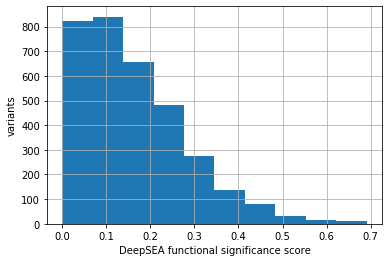

In [8]:
fig, ax = plt.subplots()
D['deepsea_Functional Significance Score'].hist(ax=ax)
ax.set_xlabel('DeepSEA functional significance score')
ax.set_ylabel('variants')
attila_utils.savefig(fig, 'deepsea-hist')

The histogram suggests a cutoff somewhere between 0.5 and 0.6 score.  I will define functionally significant variants using both a more lenient and a more stringent threshold.

In [9]:
def insert_deepsea(thrs):
    loc = list(D.columns).index('deepsea_Functional Significance Score') + 1
    value = D['deepsea_Functional Significance Score'] >= thrs
    column = 'deepsea_Functional Significance Score >= ' + str(thrs)
    if not column in D.columns:
        D.insert(loc=loc, column=column, value=value)
    count = D[column].sum()
    print(count, 'variants with', column)
    return(None)

insert_deepsea(0.6)
insert_deepsea(0.5)

15 variants with deepsea_Functional Significance Score >= 0.6
55 variants with deepsea_Functional Significance Score >= 0.5


### Ensembl gene description

In [10]:
outcsv = '/home/attila/projects/bsm/results/2020-11-13-functional-variants/expanded-annotated-calls.csv'
# a long run
if not os.path.exists(outcsv):
    description = SNPnexus.ensembl_description(data, colname='near_gens_Overlapped Gene set')
    D = SNPnexus.insert_col(description, D, 'near_gens_Overlapped Gene set', 'near_gens_Overlapped Gene set description', inplace=False)
    D.to_csv(outcsv)

## Filterings

In [11]:
filtl = ['coding nonsyn', 'stop-gain', 'intronic (splice_site)', 'regbuild_Epigenome_nervoussys_bin', 'tfbs_TFBS Name_bin', 'Deleterious', 'Deleterious - Low Confidence', 'deepsea_Functional Significance Score >= 0.6', 'gerp_Element RS Score_bin']
counts = funcvar.filtered_Dx_counts(D, filtl=filtl, gb='Dx')
counts

Dx,Control,SCZ,Total
coding nonsyn,15,44,59
stop-gain,0,4,4
intronic (splice_site),0,1,1
regbuild_Epigenome_nervoussys_bin,208,521,729
tfbs_TFBS Name_bin,22,79,101
Deleterious,6,14,20
Deleterious - Low Confidence,1,3,4
deepsea_Functional Significance Score >= 0.6,3,12,15
gerp_Element RS Score_bin,75,265,340


### Functional variants

First let's see Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

In [12]:
funcAby_cols = ['coding nonsyn', 'stop-gain', 'intronic (splice_site)', 'tfbs_TFBS Name_bin', 'regbuild_Epigenome_nervoussys_bin']

def get_funcAby(cols=funcAby_cols, df=D):
    l = [df[s] for s in cols]
    val = functools.reduce(lambda x, y: x | y, l)
    return(val)

funcAby = functools.reduce(lambda x, y: x | y, [D[s] for s in funcAby_cols])
funcAby_no_regulatory = functools.reduce(lambda x, y: x | y, [D[s] for s in funcAby_cols[:-1]])
print('Functional variants according to criteria by the Abyzov lab:')
print(sum(funcAby), 'total')
print(sum(funcAby_no_regulatory), 'excluding regulatory')

Functional variants according to criteria by the Abyzov lab:
840 total
143 excluding regulatory


In [13]:
sel_cols = ['Dx', 'near_gens_Overlapped Gene', 'near_gens_Overlapped SCZ GWAS Genes', 'encode_Feature Type Class']

### Coding variants predicted as deleterious

In [14]:
D.loc[D['Deleterious'], sel_cols]#.sort_values(by='Dx')

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_055  NeuN_pl 4     187194260 C/T       Control   
CMC_MSSM_097  NeuN_pl 3     49330027  A/G           SCZ   
                      11    126136475 G/A           SCZ   
CMC_MSSM_099  NeuN_pl 3     49083922  C/T       Control   
CMC_MSSM_100  NeuN_pl 6     42986648  C/A       Control   
                      7     128480112 G/A       Control   
CMC_MSSM_106  NeuN_pl 10    33474609  A/G       Control   
                      16    1537659   C/T       Control   
CMC_MSSM_142  NeuN_pl 13    21742430  C/T           SCZ   
CMC_MSSM_162  NeuN_pl 12    104682742 A/C           SCZ   
CMC_MSSM_168  NeuN_pl 12    121176354 C/T           SCZ   
CMC_MSSM_180  NeuN_pl 3     169540341 C/T           SCZ   
CMC_MSSM_224  NeuN_pl 16    682738    G/A           SCZ   
                      19    15271813  G/A           SCZ   
CMC_MSSM_362  NeuN_pl 10    81929099  C/T           SCZ   
CMC_MSSM_363  NeuN_pl 1     22176560  C/T           SCZ   
CMC_MSSM_379  NeuN_pl 19    19308414  G/A           SCZ   
CMC_MSSM_415  NeuN_pl 16    90109610  A/C           SCZ   
CMC_PITT_020  NeuN_pl 6     155732472 C/T           SCZ   
CMC_PITT_052  NeuN_pl 1     167358841 G/A           SCZ   

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_055  NeuN_pl 4     187194260 C/T                            F11   
CMC_MSSM_097  NeuN_pl 3     49330027  A/G                           USP4   
                      11    126136475 G/A                           SRPR   
CMC_MSSM_099  NeuN_pl 3     49083922  C/T                         QRICH1   
CMC_MSSM_100  NeuN_pl 6     42986648  C/A                         KLHDC3   
                      7     128480112 G/A                           FLNC   
CMC_MSSM_106  NeuN_pl 10    33474609  A/G                           NRP1   
                      16    1537659   C/T                           PTX4   
CMC_MSSM_142  NeuN_pl 13    21742430  C/T                           SKA3   
CMC_MSSM_162  NeuN_pl 12    104682742 A/C                         TXNRD1   
CMC_MSSM_168  NeuN_pl 12    121176354 C/T                          ACADS   
CMC_MSSM_180  NeuN_pl 3     169540341 C/T                         LRRIQ4   
CMC_MSSM_224  NeuN_pl 16    682738    G/A                        WFIKKN1   
                      19    15271813  G/A                         NOTCH3   
CMC_MSSM_362  NeuN_pl 10    81929099  C/T                         ANXA11   
CMC_MSSM_363  NeuN_pl 1     22176560  C/T                          HSPG2   
CMC_MSSM_379  NeuN_pl 19    19308414  G/A                         RFXANK   
CMC_MSSM_415  NeuN_pl 16    90109610  A/C                     GAS8:URAHP   
CMC_PITT_020  NeuN_pl 6     155732472 C/T                           NOX3   
CMC_PITT_052  NeuN_pl 1     167358841 G/A                         POU2F1   

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_055  NeuN_pl 4     187194260 C/T                                       {}   
CMC_MSSM_097  NeuN_pl 3     49330027  A/G                                       {}   
                      11    126136475 G/A                                       {}   
CMC_MSSM_099  NeuN_pl 3     49083922  C/T                                       {}   
CMC_MSSM_100  NeuN_pl 6     42986648  C/A                                       {}   
                      7     128480112 G/A                                       {}   
CMC_MSSM_106  NeuN_pl 10    33474609  A/G                                       {}   
                      16    1537659   C/T                                       {}   
CMC_MSSM_142  NeuN_pl 13    21742430  C/T                                       {}   
CMC_MSSM_162  NeuN_pl 12    104682742 A/C                                       {}   
CMC_MSSM_168  NeuN_pl 12    121176354 C/T        

### Noncoding variants predicted as functional

In [15]:
D.loc[D['deepsea_Functional Significance Score >= 0.6'], sel_cols]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_100  NeuN_pl X     79208397  T/A       Control   
CMC_MSSM_130  NeuN_pl 6     115507207 T/C       Control   
CMC_MSSM_168  NeuN_pl 20    47794232  T/A           SCZ   
CMC_MSSM_178  NeuN_pl 2     139696021 T/G       Control   
CMC_MSSM_180  NeuN_pl 11    88899522  G/A           SCZ   
CMC_MSSM_222  NeuN_pl 11    9176379   T/A           SCZ   
CMC_MSSM_224  NeuN_pl 3     4984807   T/C           SCZ   
CMC_MSSM_305  NeuN_pl 9     107282115 T/A           SCZ   
                      13    87792531  T/C           SCZ   
CMC_MSSM_343  NeuN_pl 13    84127480  G/T           SCZ   
CMC_MSSM_352  NeuN_pl 3     148084503 A/T           SCZ   
CMC_MSSM_366  NeuN_pl 1     110126012 T/A           SCZ   
CMC_PITT_020  NeuN_pl 4     146490796 G/C           SCZ   
CMC_PITT_071  NeuN_pl 13    55121881  A/T           SCZ   
CMC_PITT_072  NeuN_pl 5     82059915  C/A           SCZ   

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_100  NeuN_pl X     79208397  T/A                           None   
CMC_MSSM_130  NeuN_pl 6     115507207 T/C                           None   
CMC_MSSM_168  NeuN_pl 20    47794232  T/A                          STAU1   
CMC_MSSM_178  NeuN_pl 2     139696021 T/G                           None   
CMC_MSSM_180  NeuN_pl 11    88899522  G/A                           None   
CMC_MSSM_222  NeuN_pl 11    9176379   T/A                        DENND5A   
CMC_MSSM_224  NeuN_pl 3     4984807   T/C                    BHLHE40-AS1   
CMC_MSSM_305  NeuN_pl 9     107282115 T/A                           None   
                      13    87792531  T/C                           None   
CMC_MSSM_343  NeuN_pl 13    84127480  G/T                           None   
CMC_MSSM_352  NeuN_pl 3     148084503 A/T                   RP11-501O2.5   
CMC_MSSM_366  NeuN_pl 1     110126012 T/A                          GNAI3   
CMC_PITT_020  NeuN_pl 4     146490796 G/C                           None   
CMC_PITT_071  NeuN_pl 13    55121881  A/T                           None   
CMC_PITT_072  NeuN_pl 5     82059915  C/A                           None   

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_100  NeuN_pl X     79208397  T/A                                       {}   
CMC_MSSM_130  NeuN_pl 6     115507207 T/C                                       {}   
CMC_MSSM_168  NeuN_pl 20    47794232  T/A                                       {}   
CMC_MSSM_178  NeuN_pl 2     139696021 T/G                                       {}   
CMC_MSSM_180  NeuN_pl 11    88899522  G/A                                       {}   
CMC_MSSM_222  NeuN_pl 11    9176379   T/A                                       {}   
CMC_MSSM_224  NeuN_pl 3     4984807   T/C                                       {}   
CMC_MSSM_305  NeuN_pl 9     107282115 T/A                                       {}   
                      13    87792531  T/C                                       {}   
CMC_MSSM_343  NeuN_pl 13    84127480  G/T                                       {}   
CMC_MSSM_352  NeuN_pl 3     148084503 A/T                                       {}   
CMC_MSSM_366  NeuN_pl 1     110126012 T/A                                       {}   
CMC_PITT_020  NeuN_pl 4     146490796 G/C                                       {}   
CMC_PITT_071  NeuN_pl 13    55121881  A/T                                       {}   
CMC_PITT_072  NeuN_pl 5     82059915  C/A                                       {}   

                                               encode_Feature Type Class  
Individual ID Tissue  CHROM POS       Mutation                            
CMC_MSSM_100  NeuN_pl X     79208397  T/A                        Histone  
CMC_MSSM_130  NeuN_pl 6     115507207 T/C                        His

### SCZ GWAS genes overlapping functional variants 

In [16]:
counts_SCZ_GWAS = funcvar.filtered_Dx_counts(D, filtl=filtl, gb='Dx', anygwas=D['near_gens_Overlapped SCZ GWAS genes any'])
counts_SCZ_GWAS

Dx,Control,SCZ,Total
coding nonsyn,0,0,0
stop-gain,0,0,0
intronic (splice_site),0,0,0
regbuild_Epigenome_nervoussys_bin,6,13,19
tfbs_TFBS Name_bin,0,2,2
Deleterious,0,0,0
Deleterious - Low Confidence,0,0,0
deepsea_Functional Significance Score >= 0.6,0,0,0
gerp_Element RS Score_bin,1,9,10


#### Functional variants with overlapping SCZ GWAS gene(s)

In [17]:
D.loc[funcAby & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_097  NeuN_pl 8     143313835 A/C           SCZ   
CMC_MSSM_106  NeuN_pl 6     143541413 A/G       Control   
CMC_MSSM_109  NeuN_pl 3     60745841  C/T       Control   
                      6     128820938 T/C       Control   
CMC_MSSM_213  NeuN_pl 15    78913052  T/G           SCZ   
                      16    7455256   C/T           SCZ   
                      17    78573310  T/G           SCZ   
                            78699501  A/C           SCZ   
CMC_MSSM_224  NeuN_pl 2     233752670 C/T           SCZ   
                      17    78669726  G/A           SCZ   
CMC_MSSM_273  NeuN_pl 8     10184212  A/G           SCZ   
CMC_MSSM_305  NeuN_pl 14    33173083  G/A           SCZ   
CMC_MSSM_340  NeuN_pl 3     53703284  C/G           SCZ   
CMC_MSSM_343  NeuN_pl 8     143385292 T/G           SCZ   
CMC_MSSM_352  NeuN_pl 1     97845569  T/A           SCZ   
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       Control   
                      19    19367011  C/T       Control   
CMC_PITT_020  NeuN_pl 6     128611543 C/A           SCZ   
CMC_PITT_050  NeuN_pl 16    68271265  G/A       Control   
CMC_PITT_118  NeuN_pl 3     17343154  C/T           SCZ   
                      X     5889841   G/A           SCZ   

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_097  NeuN_pl 8     143313835 A/C                        TSNARE1   
CMC_MSSM_106  NeuN_pl 6     143541413 A/G                           AIG1   
CMC_MSSM_109  NeuN_pl 3     60745841  C/T                           FHIT   
                      6     128820938 T/C                          PTPRK   
CMC_MSSM_213  NeuN_pl 15    78913052  T/G                         CHRNA3   
                      16    7455256   C/T                         RBFOX1   
                      17    78573310  T/G                          RPTOR   
                            78699501  A/C                          RPTOR   
CMC_MSSM_224  NeuN_pl 2     233752670 C/T                           NGEF   
                      17    78669726  G/A                          RPTOR   
CMC_MSSM_273  NeuN_pl 8     10184212  A/G                           MSRA   
CMC_MSSM_305  NeuN_pl 14    33173083  G/A                          AKAP6   
CMC_MSSM_340  NeuN_pl 3     53703284  C/G                        CACNA1D   
CMC_MSSM_343  NeuN_pl 8     143385292 T/G                        TSNARE1   
CMC_MSSM_352  NeuN_pl 1     97845569  T/A                           DPYD   
CMC_MSSM_369  NeuN_pl 12    23913864  G/A                           SOX5   
                      19    19367011  C/T              HAPLN4:AC138430.4   
CMC_PITT_020  NeuN_pl 6     128611543 C/A                          PTPRK   
CMC_PITT_050  NeuN_pl 16    68271265  G/A              ESRP2:RP11-96D1.6   
CMC_PITT_118  NeuN_pl 3     17343154  C/T                         TBC1D5   
                      X     5889841   G/A                         NLGN4X   

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_097  NeuN_pl 8     143313835 A/C                                {TSNARE1}   
CMC_MSSM_106  NeuN_pl 6     143541413 A/G                                   {AIG1}   
CMC_MSSM_109  NeuN_pl 3     60745841  C/T                                   {FHIT}   
                      6     128820938 T/C                                  {PTPRK}   
CMC_MSSM_213  NeuN_pl 15    78913052  T/G                                 {CHRNA3}   
                      16    7455256   C/T                                 {RBFOX1}   
                      17    78573310  T/G                                  {RPTOR}   
                            78699501  A/C                                  {RPTOR}   
CMC_MSSM_224  NeuN_pl 2     233752670 C/T                                   {NGEF}   


TSNARE1 is [t-SNARE domain-containing protein 1](https://www.uniprot.org/uniprot/Q96NA8)

AIG1 is [Androgen-induced gene 1 protein](https://www.uniprot.org/uniprot/Q9NVV5), which
> Hydrolyzes bioactive fatty-acid esters of hydroxy-fatty acids

FHIT is [Bis(5'-adenosyl)-triphosphatase](https://www.uniprot.org/uniprot/P49789), which
> Modulates transcriptional activation by CTNNB1 and thereby contributes to regulate the expression of genes essential for cell proliferation and survival, such as CCND1 and BIRC5. Plays a role in the induction of apoptosis via SRC and AKT1 signaling pathways.

PTPRK is [Receptor-type tyrosine-protein phosphatase kappa](https://www.uniprot.org/uniprot/Q15262), which is involved in
> Regulation of processes involving cell contact and adhesion such as growth control, tumor invasion, and metastasis. Negative regulator of EGFR signaling pathway.

CHRNA3 is [Neuronal acetylcholine receptor subunit alpha-3](https://www.uniprot.org/uniprot/P32297)

RBFOX1 is [RNA binding protein fox-1 homolog 1](https://www.uniprot.org/uniprot/Q9NWB1), which
> Regulates alternative splicing of tissue-specific exons and of differentially spliced exons during erythropoiesis.

RPTOR is [Regulatory-associated protein of mTOR](https://www.uniprot.org/uniprot/Q8N122), which
> Involved in the control of the mammalian target of rapamycin complex 1 (mTORC1) activity which regulates cell growth and survival, and autophagy in response to nutrient and hormonal signals; functions as a scaffold for recruiting mTORC1 substrates.

#### Functional variants (excl regulatory) with overlapping SCZ GWAS gene(s)

In [18]:
D.loc[funcAby_no_regulatory & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols]

,,,,,Dx,near_gens_Overlapped Gene,near_gens_Overlapped SCZ GWAS Genes,encode_Feature Type Class
Individual ID,Tissue,CHROM,POS,Mutation,,,,
CMC_MSSM_213,NeuN_pl,17,78699501,A/C,SCZ,RPTOR,{RPTOR},Transcription Factor
CMC_PITT_020,NeuN_pl,6,128611543,C/A,SCZ,PTPRK,{PTPRK},Histone


#### Variants under evol constraint with overlapping SCZ GWAS gene(s)

In [19]:
D.loc[D['gerp_Element RS Score_bin'] & D['near_gens_Overlapped SCZ GWAS genes any'], sel_cols]

Dx  \
Individual ID Tissue  CHROM POS       Mutation            
CMC_MSSM_142  NeuN_pl 16    9879977   G/A           SCZ   
CMC_MSSM_213  NeuN_pl 6     128679817 G/A           SCZ   
CMC_MSSM_265  NeuN_pl 14    33184326  C/G           SCZ   
CMC_MSSM_305  NeuN_pl 14    33173083  G/A           SCZ   
                      16    7272405   C/T           SCZ   
CMC_MSSM_308  NeuN_pl 14    30225338  A/C           SCZ   
CMC_MSSM_340  NeuN_pl 3     53703284  C/G           SCZ   
CMC_MSSM_369  NeuN_pl 12    23913864  G/A       Control   
CMC_PITT_052  NeuN_pl 14    30404403  G/A           SCZ   
CMC_PITT_071  NeuN_pl 1     149962497 G/A           SCZ   

                                               near_gens_Overlapped Gene  \
Individual ID Tissue  CHROM POS       Mutation                             
CMC_MSSM_142  NeuN_pl 16    9879977   G/A                         GRIN2A   
CMC_MSSM_213  NeuN_pl 6     128679817 G/A                          PTPRK   
CMC_MSSM_265  NeuN_pl 14    33184326  C/G                          AKAP6   
CMC_MSSM_305  NeuN_pl 14    33173083  G/A                          AKAP6   
                      16    7272405   C/T                         RBFOX1   
CMC_MSSM_308  NeuN_pl 14    30225338  A/C                          PRKD1   
CMC_MSSM_340  NeuN_pl 3     53703284  C/G                        CACNA1D   
CMC_MSSM_369  NeuN_pl 12    23913864  G/A                           SOX5   
CMC_PITT_052  NeuN_pl 14    30404403  G/A                          PRKD1   
CMC_PITT_071  NeuN_pl 1     149962497 G/A                         OTUD7B   

                                               near_gens_Overlapped SCZ GWAS Genes  \
Individual ID Tissue  CHROM POS       Mutation                                       
CMC_MSSM_142  NeuN_pl 16    9879977   G/A                                 {GRIN2A}   
CMC_MSSM_213  NeuN_pl 6     128679817 G/A                                  {PTPRK}   
CMC_MSSM_265  NeuN_pl 14    33184326  C/G                                  {AKAP6}   
CMC_MSSM_305  NeuN_pl 14    33173083  G/A                                  {AKAP6}   
                      16    7272405   C/T                                 {RBFOX1}   
CMC_MSSM_308  NeuN_pl 14    30225338  A/C                                  {PRKD1}   
CMC_MSSM_340  NeuN_pl 3     53703284  C/G                                {CACNA1D}   
CMC_MSSM_369  NeuN_pl 12    23913864  G/A                                   {SOX5}   
CMC_PITT_052  NeuN_pl 14    30404403  G/A                                  {PRKD1}   
CMC_PITT_071  NeuN_pl 1     149962497 G/A                                 {OTUD7B}   

                                               encode_Feature Type Class  
Individual ID Tissue  CHROM POS       Mutation                            
CMC_MSSM_142  NeuN_pl 16    9879977   G/A           Transcription Factor  
CMC_MSSM_213  NeuN_pl 6     128679817 G/A           Transcription Factor  
CMC_MSSM_265  NeuN_pl 14    33184326  C/G                        Histone  
CMC_MSSM_305  NeuN_pl 14    33173083  G/A           Transcription Factor  
                      16    7272405   C/T           Transcription Factor  
CMC_MSSM_308  NeuN_pl 14    30225338  A/C                        Histone  
CMC_MSSM_340  NeuN_pl 3     53703284  C/G           Transcription Factor  
CMC_MSSM_369  NeuN_pl 12    23913864  G/A                 Open Chromatin  
CMC_PITT_052  NeuN_pl 14    30404403  G/A                        Histone  
CMC_PITT_071  NeuN_pl 1     149962497 G/A                        Histone

In [20]:
%connect_info

{
  "shell_port": 58649,
  "iopub_port": 35265,
  "stdin_port": 55549,
  "control_port": 43231,
  "hb_port": 50145,
  "ip": "127.0.0.1",
  "key": "5f5d63cb-e78fce7dbcb8d9833f7f42a2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c7c8171d-31f9-4a64-8e71-9f6ff4e9ca5f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
